## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, word_split, normalize_to_ascii

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import read_first_n, sample_batch


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [2]:
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
tokenizer = pkl.load(open("tokenizers/tokenizer_CNN16000_lowercase.pkl", 'rb'))
tokenizer.create_hash()

random.seed(42)
corpus_indicies = pkl.load(open('corpus/CNN_tokenized16000_lowercase.pkl', 'rb'))
random.shuffle(corpus_indicies)

## Define Model

In [ ]:
class WarmUpThenDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,
                 initial_learning_rate: float,
                 warmup_steps: int,
                 decay_schedule_fn: tf.keras.optimizers.schedules.LearningRateSchedule):
        """
        initial_learning_rate: peak LR reached at end of warmup
        warmup_steps:      # of steps to ramp from 0 → initial_learning_rate
        decay_schedule_fn: a tf.keras schedule to apply *after* warmup
        """
        super().__init__()
        self.initial_lr = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_schedule_fn = decay_schedule_fn

    def __call__(self, step):
        # Cast to float32 for safety in graph mode
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        # compute linear warmup: lr = initial_lr * (step / warmup_steps)
        warmup_lr = self.initial_lr * (step / warmup_steps)

        # after warmup_steps, switch to decay schedule (shift step count)
        decay_step = step - warmup_steps
        decay_lr = self.decay_schedule_fn(decay_step)

        # if step < warmup_steps, pick warmup_lr, else decay_lr
        return tf.cond(step < warmup_steps,
                       lambda: warmup_lr,
                       lambda: decay_lr)
    

class TransformerBlock(tf.keras.Model):
    def __init__(
        self,
        vocab_size,
        max_seq_len,
        heads,
        embed_dim,
        ff_dim,
        **kwargs

    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.heads = heads
        self.max_seq_len = max_seq_len
        self.ff_dim = ff_dim

        self.head_dim = embed_dim // heads

        d = tf.sqrt(tf.cast(self.head_dim, tf.float32))

        self.WK = tf.Variable(
            tf.random.uniform([heads, self.head_dim, embed_dim], -1 / d, 1 / d), name="WK"
        )
        self.WQ = tf.Variable(
            tf.random.uniform([heads, self.head_dim, embed_dim], -1 / d, 1 / d), name="WQ"
        )
        self.WV = tf.Variable(
            tf.random.uniform([heads, self.head_dim, embed_dim], -1 / d, 1 / d),
            name="WV",
        )
        self.WO = tf.Variable(
            tf.random.uniform([embed_dim, embed_dim], -1 / d, 1 / d), name="WO"
        )

        self.layer_up = DenseLayer(embed_dim, ff_dim)
        self.layer_down = DenseLayer(ff_dim, embed_dim)

        self.ln1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ln1.build((None, None, embed_dim))

        self.ln2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ln2.build((None, None, embed_dim))

        self.parameter_list = [
            self.WK,
            self.WQ,
            self.WV,
            self.WO,
        ]
        self.parameter_list += self.layer_up.parameter_list
        self.parameter_list += self.layer_down.parameter_list
        self.parameter_list += self.ln1.trainable_variables
        self.parameter_list += self.ln2.trainable_variables

        self.parameter_decay = [
            self.WK,
            self.WQ,
            self.WV,
            self.WO,
            self.layer_up.W,
            self.layer_down.W,
        ]

    def attention(self, x_embeds):
        batch = tf.shape(x_embeds)[0]
        seq = tf.shape(x_embeds)[1]

        x_k = tf.einsum("ikl, bjl -> bijk", self.WK, x_embeds)
        x_q = tf.einsum("ikl, bjl -> bijk", self.WQ, x_embeds)
        x_v = tf.einsum("ikl, bjl -> bijk", self.WV, x_embeds)

        inner = tf.einsum("bijl,bikl -> bijk", x_q, x_k)
        mask = tf.linalg.band_part(tf.ones((1, seq, seq), dtype=tf.bool), -1, 0)
        mask = tf.repeat(mask, self.heads, axis=0)

        inner_masked = tf.where(mask, inner, tf.constant(-np.inf))

        dk = tf.sqrt(tf.cast(self.head_dim, tf.float32))
        WA = tf.nn.softmax(inner_masked / dk, axis=-1)

        head_outs = WA @ x_v
        concat = tf.transpose(head_outs, [0, 2, 1, 3])  # [batch, seq, heads, head_dim]
        out = tf.reshape(concat, [batch, seq, self.embed_dim])
        out = tf.einsum("ijk,kl -> ijl", out, self.WO)

        # pre-norm to keep gradients alive
        out = self.ln1(out)
        out = out + x_embeds

        return out
    
    def ffnn(self, x_embeds):
        out = self.layer_up(x_embeds)
        out = tf.nn.relu(out)
        out = self.layer_down(out)
        out = self.ln2(out)
        out = out + x_embeds

        return out
    
    def call(self, x_embeds):
        x_embeds = self.attention(x_embeds)
        x_embeds = self.ffnn(x_embeds)

        return x_embeds



class Transformer(tf.keras.Model):
    def __init__(
        self,
        vocab_size,
        max_seq_len,
        tf_blocks,
        embed_dim,
        heads,
        ff_dim,
        unembed_dims,
        lr,
        wd=None,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.heads = heads
        self.max_seq_len = max_seq_len
        self.tf_blocks = tf_blocks
        self.ff_dim = ff_dim
        self.unembed_dims = unembed_dims
        self.wd = wd

        self.head_dim = embed_dim // heads


        d = tf.sqrt(tf.cast(self.embed_dim, tf.float32))

        self.word_embed = tf.Variable(
            tf.random.uniform([vocab_size, embed_dim], -1 / d, 1 / d), name="word_embed"
        )
        self.pos_embed = tf.Variable(
            tf.random.uniform([max_seq_len, embed_dim], -1 / d, 1 / d), name="pos_embed"
        )

        self.tf_blocks = []
        for i in range(tf_blocks):
            self.tf_blocks.append(TransformerBlock(vocab_size, max_seq_len, heads, embed_dim, ff_dim))
    

        self.unembed_dims.insert(0, embed_dim)
        self.unembed_dims.append(vocab_size)
        self.unembed_layers = []
        for i in range(len(unembed_dims) - 1):
            self.unembed_layers.append(DenseLayer(unembed_dims[i], unembed_dims[i + 1]))


        self.parameter_list = [
            self.word_embed,
            self.pos_embed,
        ]

        for block in self.tf_blocks:
            self.parameter_list += block.parameter_list
        for layer in self.unembed_layers:
            self.parameter_list += layer.parameter_list

        self.parameter_decay = [
            self.word_embed,
            self.pos_embed,]
        
        for block in self.tf_blocks:
            self.parameter_decay += block.parameter_decay
        for layer in self.unembed_layers:
            self.parameter_decay.append(layer.W)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    def call(self, x):

        x_embeds = self.embed(x)
        for block in self.tf_blocks:
            x_embeds = block.call(x_embeds)
        
        y_pred = self.unembed(x_embeds)

        return y_pred

    def embed(self, x):
        seq = tf.shape(x)[1]
        if seq > self.max_seq_len:
            x = x[:, -self.max_seq_len :]
            seq = self.max_seq_len
        x_embeds = tf.nn.embedding_lookup(self.word_embed, x)
        x_embeds = x_embeds + tf.expand_dims(self.pos_embed[:seq], axis=0)

        return x_embeds

    def unembed(self, x_embeds):
        for layer in self.unembed_layers[:-1]:
            x_embeds = layer(x_embeds)
            x_embeds = tf.nn.relu(x_embeds)

        logits = self.unembed_layers[-1](x_embeds)

        return logits

    @tf.function()
    def train_step(self, indices, y_true):

        with tf.GradientTape() as tape:
            loss = self.evaluate(indices, y_true)

        grads = tape.gradient(loss, self.parameter_list)
        self.optimizer.apply_gradients(zip(grads, self.parameter_list))

        get_lr = self.optimizer._decayed_lr(tf.float32)
        
        if self.wd is not None:
            for param in self.parameter_decay:
                param.assign_sub(get_lr*self.wd * param)
                
        return loss

    def evaluate(self, indices, y_true):
        y_true = y_true[:, 1:]
        
        y_pred = self.call(indices)[:, :-1]
        loss = tf.math.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))
        return loss

In [6]:
initial_lr = 1e-4
decay_steps = 50000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 10000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

max_seq_len = 200
embed_dim = 1024
tf_blocks = 8
heads = 8
ff_dim = 4*embed_dim

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    lr=lr_schedule,
                    wd = 0.01,
                    )

losses_train = []
losses_test = []


In [7]:
name = "model_16k_tokens_lowercase_8blocks"


ckpt = tf.train.Checkpoint(
    optimizer=model.optimizer,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [6]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [8]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 133869254


KeyboardInterrupt: 

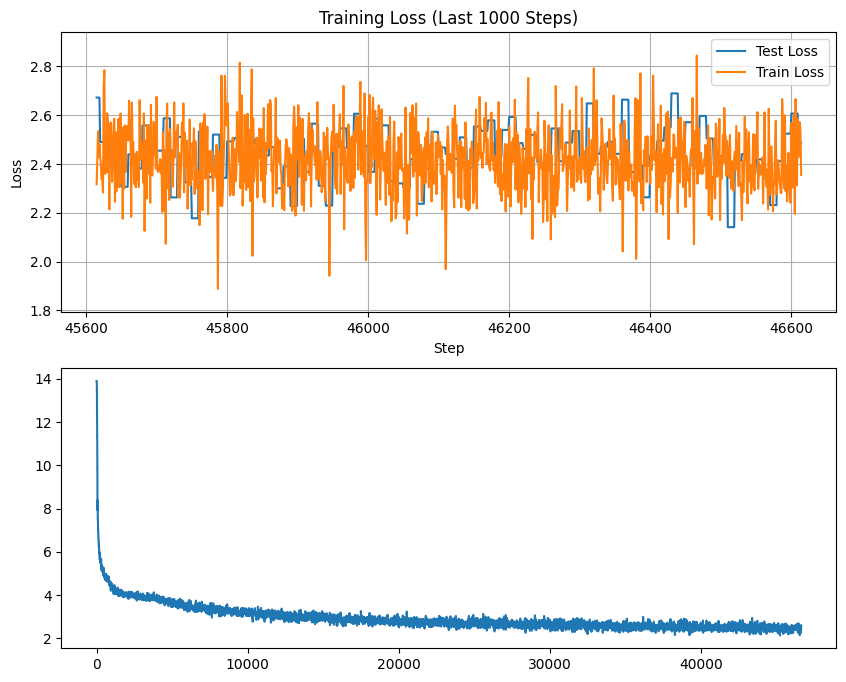

In [9]:
batch_size = 8
for i in tqdm(range(100000)):
    indices, y_true = sample_batch(corpus_indicies[:90000], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    
    loss_train = model.train_step(indices, y_true).numpy()
    losses_train.append(loss_train)


    if i % 10 == 0:
        indices, y_true = sample_batch(corpus_indicies[90000:], 
                                    batch_size, 
                                    tokenizer, 
                                    max_seq_len)
        
        loss_test = model.evaluate(indices, y_true).numpy()
        
    losses_test.append(loss_test)

    if (i+1) % 1000 == 0:
        ckpt_manager.save()
        pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))

    clear_output(wait=True)

    # prepare x-axis for the last 400 steps
    start = max(0, len(losses_train) - 1000)
    x_zoom = np.arange(start, len(losses_train))

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

    # Top subplot: zoom on last 400 steps
    ax1 = axes[0]
    ax1.plot(x_zoom, losses_test[-1000:], label="Test Loss")
    ax1.plot(x_zoom, losses_train[-1000:], label="Train Loss")

    _min = min(losses_train[-1000:] + losses_test[-1000:])
    _max = max(losses_train[-1000:] + losses_test[-1000:])
    delta = _max - _min
    ax1.set_ylim(_min - 0.1 * delta, _max + 0.1 * delta)

    ax1.set_title("Training Loss (Last 1000 Steps)")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Bottom subplot: full series
    ax2 = axes[1]
    ax2.plot(losses_test, label="Test Loss")
    ax2.plot(losses_train, label="Train Loss")

    ax2.set_title("Training Loss (Full Series)")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

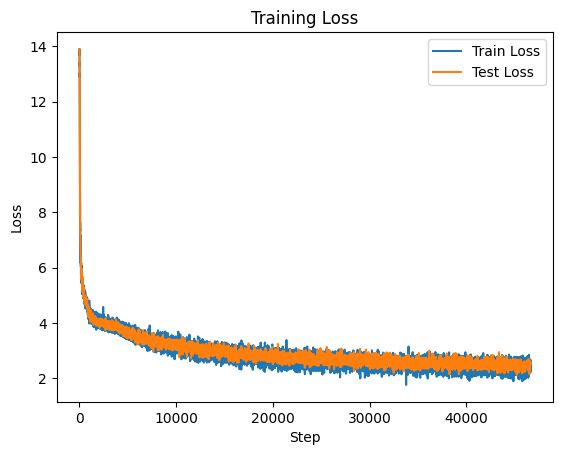

In [10]:
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_test, label="Test Loss")
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
def tokenize(indices, merge_list):
    indices = np.array(indices)
    for pair, new_idx in merge_list:
        slice = np.where(np.logical_and(indices[:-1] == pair[0],  indices[1:] == pair[1]))
        if len(slice[0]) > 0:
            indices[:-1][slice] = new_idx
            indices = np.delete(indices, (slice[0]+1))

    return tf.expand_dims(tf.convert_to_tensor(indices, dtype=tf.int32), axis=0)

In [14]:
text = "Obama's"
text = text.lower()

indices = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices = tokenize(indices, tokenizer.merge_list)
print(indices)

tf.Tensor([[2335]], shape=(1, 1), dtype=int32)


In [15]:
T = 0.5
tf.random.set_seed(42)
for i in range(200):
    logits = model.call(indices)[0,-1:]
    idx = tf.cast(tf.random.categorical(logits/T, num_samples=1), tf.int32)
    indices = tf.concat([indices, idx], axis=1)
    text_pred = tokenizer.detokenize(indices)
    text_pred = text_pred.numpy()[0].decode('utf-8').replace("\n", " ")
    print(text_pred, end='\r', flush=True)
    #time.sleep(0.05)


In [116]:
text = "obama"
text = text.lower()

indices1 = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices1 = tokenize(indices1, tokenizer.merge_list)
print(indices1)

tf.Tensor([[551]], shape=(1, 1), dtype=int32)


In [99]:
text = "Washington"
text = text.lower()

indices2 = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
indices2 = tokenize(indices2, tokenizer.merge_list)
print(indices2)

tf.Tensor([[1095]], shape=(1, 1), dtype=int32)


In [117]:
embed1 = model.embed(indices1)[0]
embed2 = model.embed(indices2)[0]

print(embed1.shape)

(1, 1024)


In [118]:
word_embed = model.word_embed

In [120]:
cosine_sim = tf.math.reduce_sum(word_embed*embed1, axis=1)/(tf.norm(word_embed, axis=1)*tf.norm(embed1))

In [121]:
idx = tf.argsort(cosine_sim, axis=-1, direction='DESCENDING', stable=False, name=None)


In [122]:
for i in idx:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

obama
obama's
romney
nixon
president's
clinton
mccain
biden
romney's
bush
white
boehner
presidents
holder
republicans
democrats
karzai
republican
gop
rubio
president
netanyahu
carter
he
ril
corporate
sandy
america's
gates
brief
syrian
reagan
clinton's
bipartisan
congressional
kerry
orum
cruz
christie
lincoln
obamacare
essentially
palin
legislative
senator
conservatives
washington
democratic
aide
partisan
liberal
congress
sean
xi
nelson
putin
he'd
america
itself
his
jobs
mcconnell
coordin
liber
ahmadinejad
amendment
voters
administration's
largely
general
probably
cbs
tone
chicago
effectively
davis
equally
repeatedly
ourselves
speech
enda
democrat
senior
veterans
rican
elected
kennedy
entre
foreign
adviser
assad
cleve
perhaps
deleg
political
hispanic
reaching
our
senators
spoken
overall
american
himself
pentagon
publicly
relatively
strategic
campaign
warren
itzer
boarding
politician
laden
russia's
actual
father's
isol
legally
sey
private
negoti
europe's
tobacco
perfor
cuban
cia
powers
s

In [ ]:
word_embed = model.word_embed
word_unembed = np.array(model.unembed_layers[0].W).T

In [20]:
print(word_embed[:10, :10])

print(word_unembed[:10, :10])

tf.Tensor(
[[ 0.00921908  0.00075292 -0.01544855 -0.01489548 -0.03303341  0.00471788
   0.02504398  0.02856879 -0.01700242 -0.00922652]
 [ 0.01526755  0.01144028 -0.00933617 -0.01863204 -0.02834815 -0.00219507
   0.0123333   0.00899256  0.00311589 -0.00245098]
 [ 0.00606975 -0.02794329  0.0055465  -0.02501583  0.00586702 -0.0047441
   0.03493392  0.00252196  0.01089943  0.03674642]
 [-0.01279819 -0.00935395 -0.03261637 -0.02698359  0.01248539 -0.01164681
   0.01151246  0.02608427 -0.03260247 -0.02689156]
 [ 0.03930734 -0.01197487 -0.06012096  0.00659124 -0.01024234 -0.01284428
   0.00627699 -0.00605494 -0.00047838  0.04084416]
 [-0.04683053  0.00854138  0.03763397 -0.05712338 -0.03244174 -0.01974531
   0.02352742  0.01087811 -0.02915147  0.04908179]
 [ 0.00946127 -0.06831864 -0.00438396 -0.00816374 -0.01219778 -0.01084389
   0.0066864   0.01358302 -0.03110292 -0.00388313]
 [ 0.01578677 -0.00800972  0.01383729  0.0187795   0.03012165  0.03125769
  -0.00585191  0.02374976 -0.0235657  -0.

## 